#MNIST with PyTorch


##1. Imports

In [16]:
import torch
import torch.nn as nn #conv, linear layer implementation
import torch.nn.functional as F #using as a function
import torch.optim as optim # optimizer(SGD, Adam, etc)
#torchvision - image dataset & preprocessor tool
from torchvision import datasets, transforms
from torch.utils.data import DataLoader #pass data in batch
import matplotlib.pyplot as plt #image/graph visualization
import numpy as np

##2. Load MNIST Data

In [3]:
#image data transform into tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

#mnist is pre-splitted into training set(60k images) & test set (10k images)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#have to shuffle data every epoch during train to prevent model from memorizing the sequence
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#no need to update model param -> X have to shuffle as the result stays the same.

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 92.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 31.4MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 44.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.71MB/s]


Number of training samples: 60000
Number of test samples: 10000


Q: Why do we need `transforms.Normalize((0.5,), (0.5,))`?

A:
- Too large/small input value -> exploding/vanishing gradient problem
- ToTensor() makes pixel value 0~255 -> 0.0~1.0
- doing normalize makes the range -1.0~1.0 to make normal distribution (make mean on 0)
- this leads to stable, faster training.




##3. Data Visulization

Shape of images: torch.Size([64, 1, 28, 28])
Shape of labels: torch.Size([64])


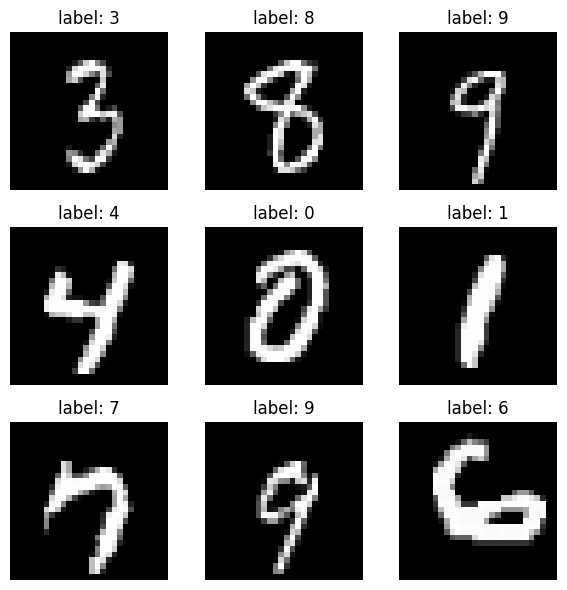

In [5]:
images, labels = next(iter(train_loader))

print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

#visualization - 9 pics
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flat):
  img = images[i].squeeze()
  ax.imshow(img, cmap='gray')
  ax.set_title(f"label: {labels[i].item()}")
  ax.axis('off')
plt.tight_layout()
plt.show()

`torch.Size([64, 1, 28, 28)]`
means..
```
(64, 1, 28, 28)
  ↑   ↑   ↑  ↑
  │   │   │  └─ image_width (28 pixels)
  │   │   └──── image_height (28 pixels)
  │   └──────── channel # (1 = grayscale,  3 = RGB)
  └──────────── batch size (1 batch has 64 imgs)
  ```

##4. CNN Model Define

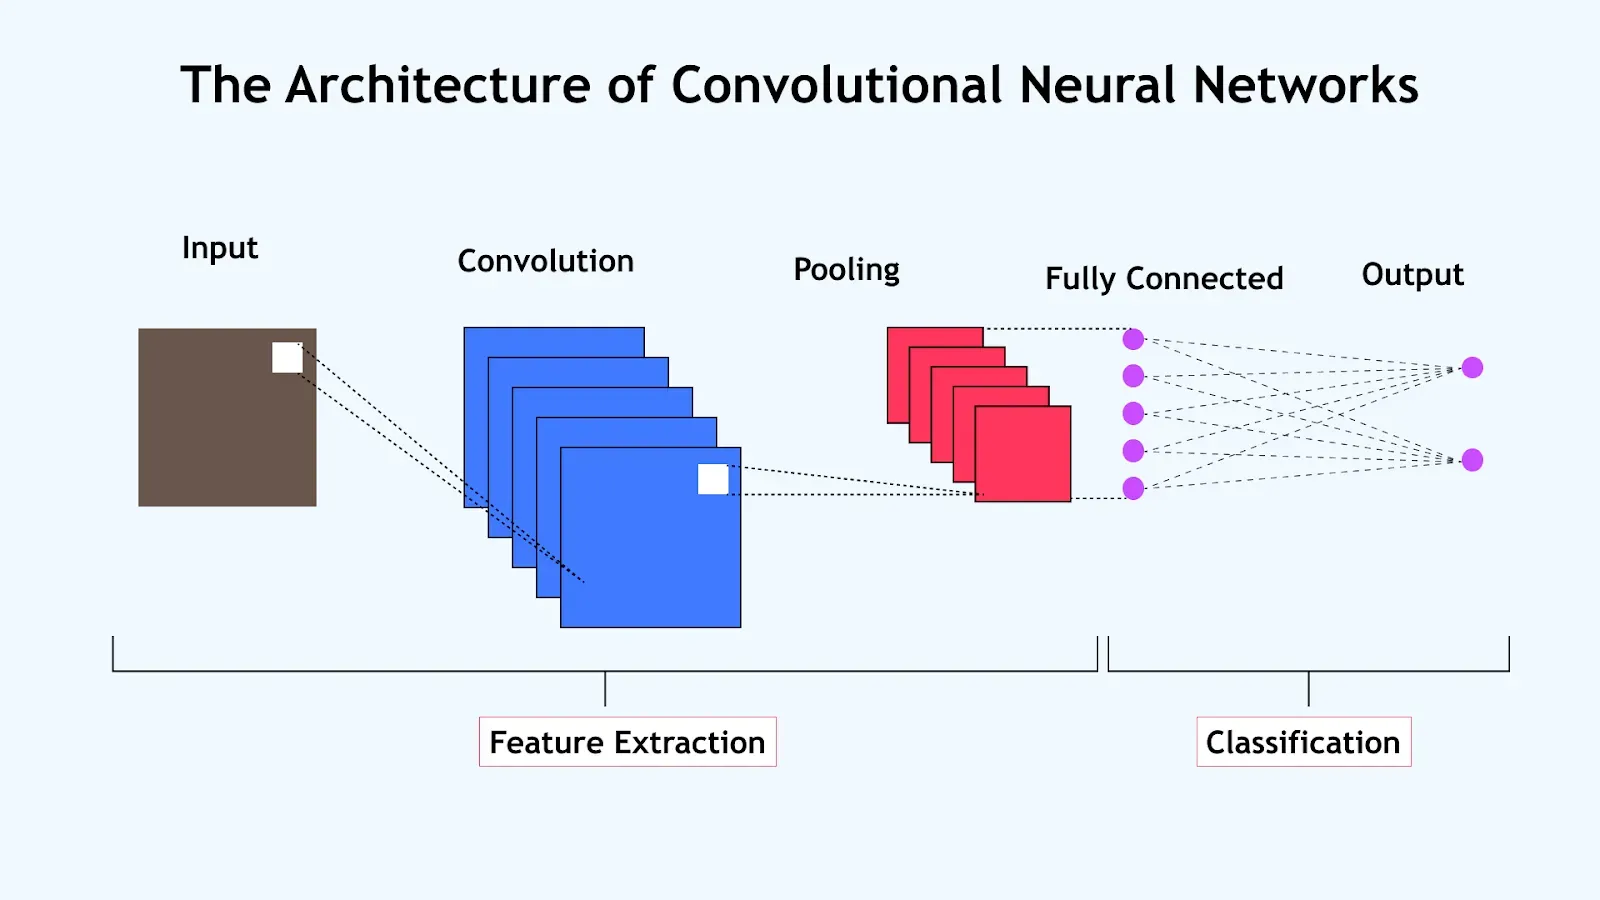

In [17]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()

    #Conv layers
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) #(64, 32, 28, 28)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #(64, 64, 14, 14)
    self.pool = nn.MaxPool2d(2)

    #FC Layers
    self.fc1 = nn.Linear(64*7*7, 128)
    self.fc2 = nn.Linear(128,10)

    #Dropout (prevent overfitting)
    self.dropout = nn.Dropout(p=0.5)


  def forward(self, x):
    #Conv block 1
    x = self.pool(F.relu(self.conv1(x))) #(64,32,28,28) -> (64,32,14,14)
    #Conv block 2
    x = self.pool(F.relu(self.conv2(x))) #(64,64,14,14) -> (64,64,7,7)
    #Flatten
    x = x.view(x.size(0), -1) #preserve batch size, flatten rest of them (=nn.Flatten()(x))
    #FC
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.fc2(x)

    return x #(64, 10) logit

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
`

- in_channels (int): # of input channel. ex) RGB img has 3 channel -> in_channels=3
- out_channels (int): # of output channel (=# of convolutional filter); larger the #, more complex but the model param # increases
- kernel_size (int/tuple): SIZE of conv filter. ex) 3x3 filter -> kernel_size=3
- stride (int/tuple, optional): 1 by default, larger stride -> smaller feature map size
- padding (int/tuple, optional): size of padding on the edge of input data. 0 by default. preserving the output feature map size & input data's edge information
- dilation (int/tuple, optional): 1 by default; larger the rate, larger the filter area
- groups(int, optional): grouping # of input&output channel. 1 by default.
- bias(bool, optional): flag whether using Bias or not. True by deafult, false meaning X using bias.

##Padding Equation
`output_size=(input_size - kernel_size + 2*padding) / stride+1`

outputsize = input_size = 28

$28 = (28 - 3 + 2p) / 1 + 1$

$28 = 25 + 2p + 1$

padding = 1

##From Input Image to Output Shape

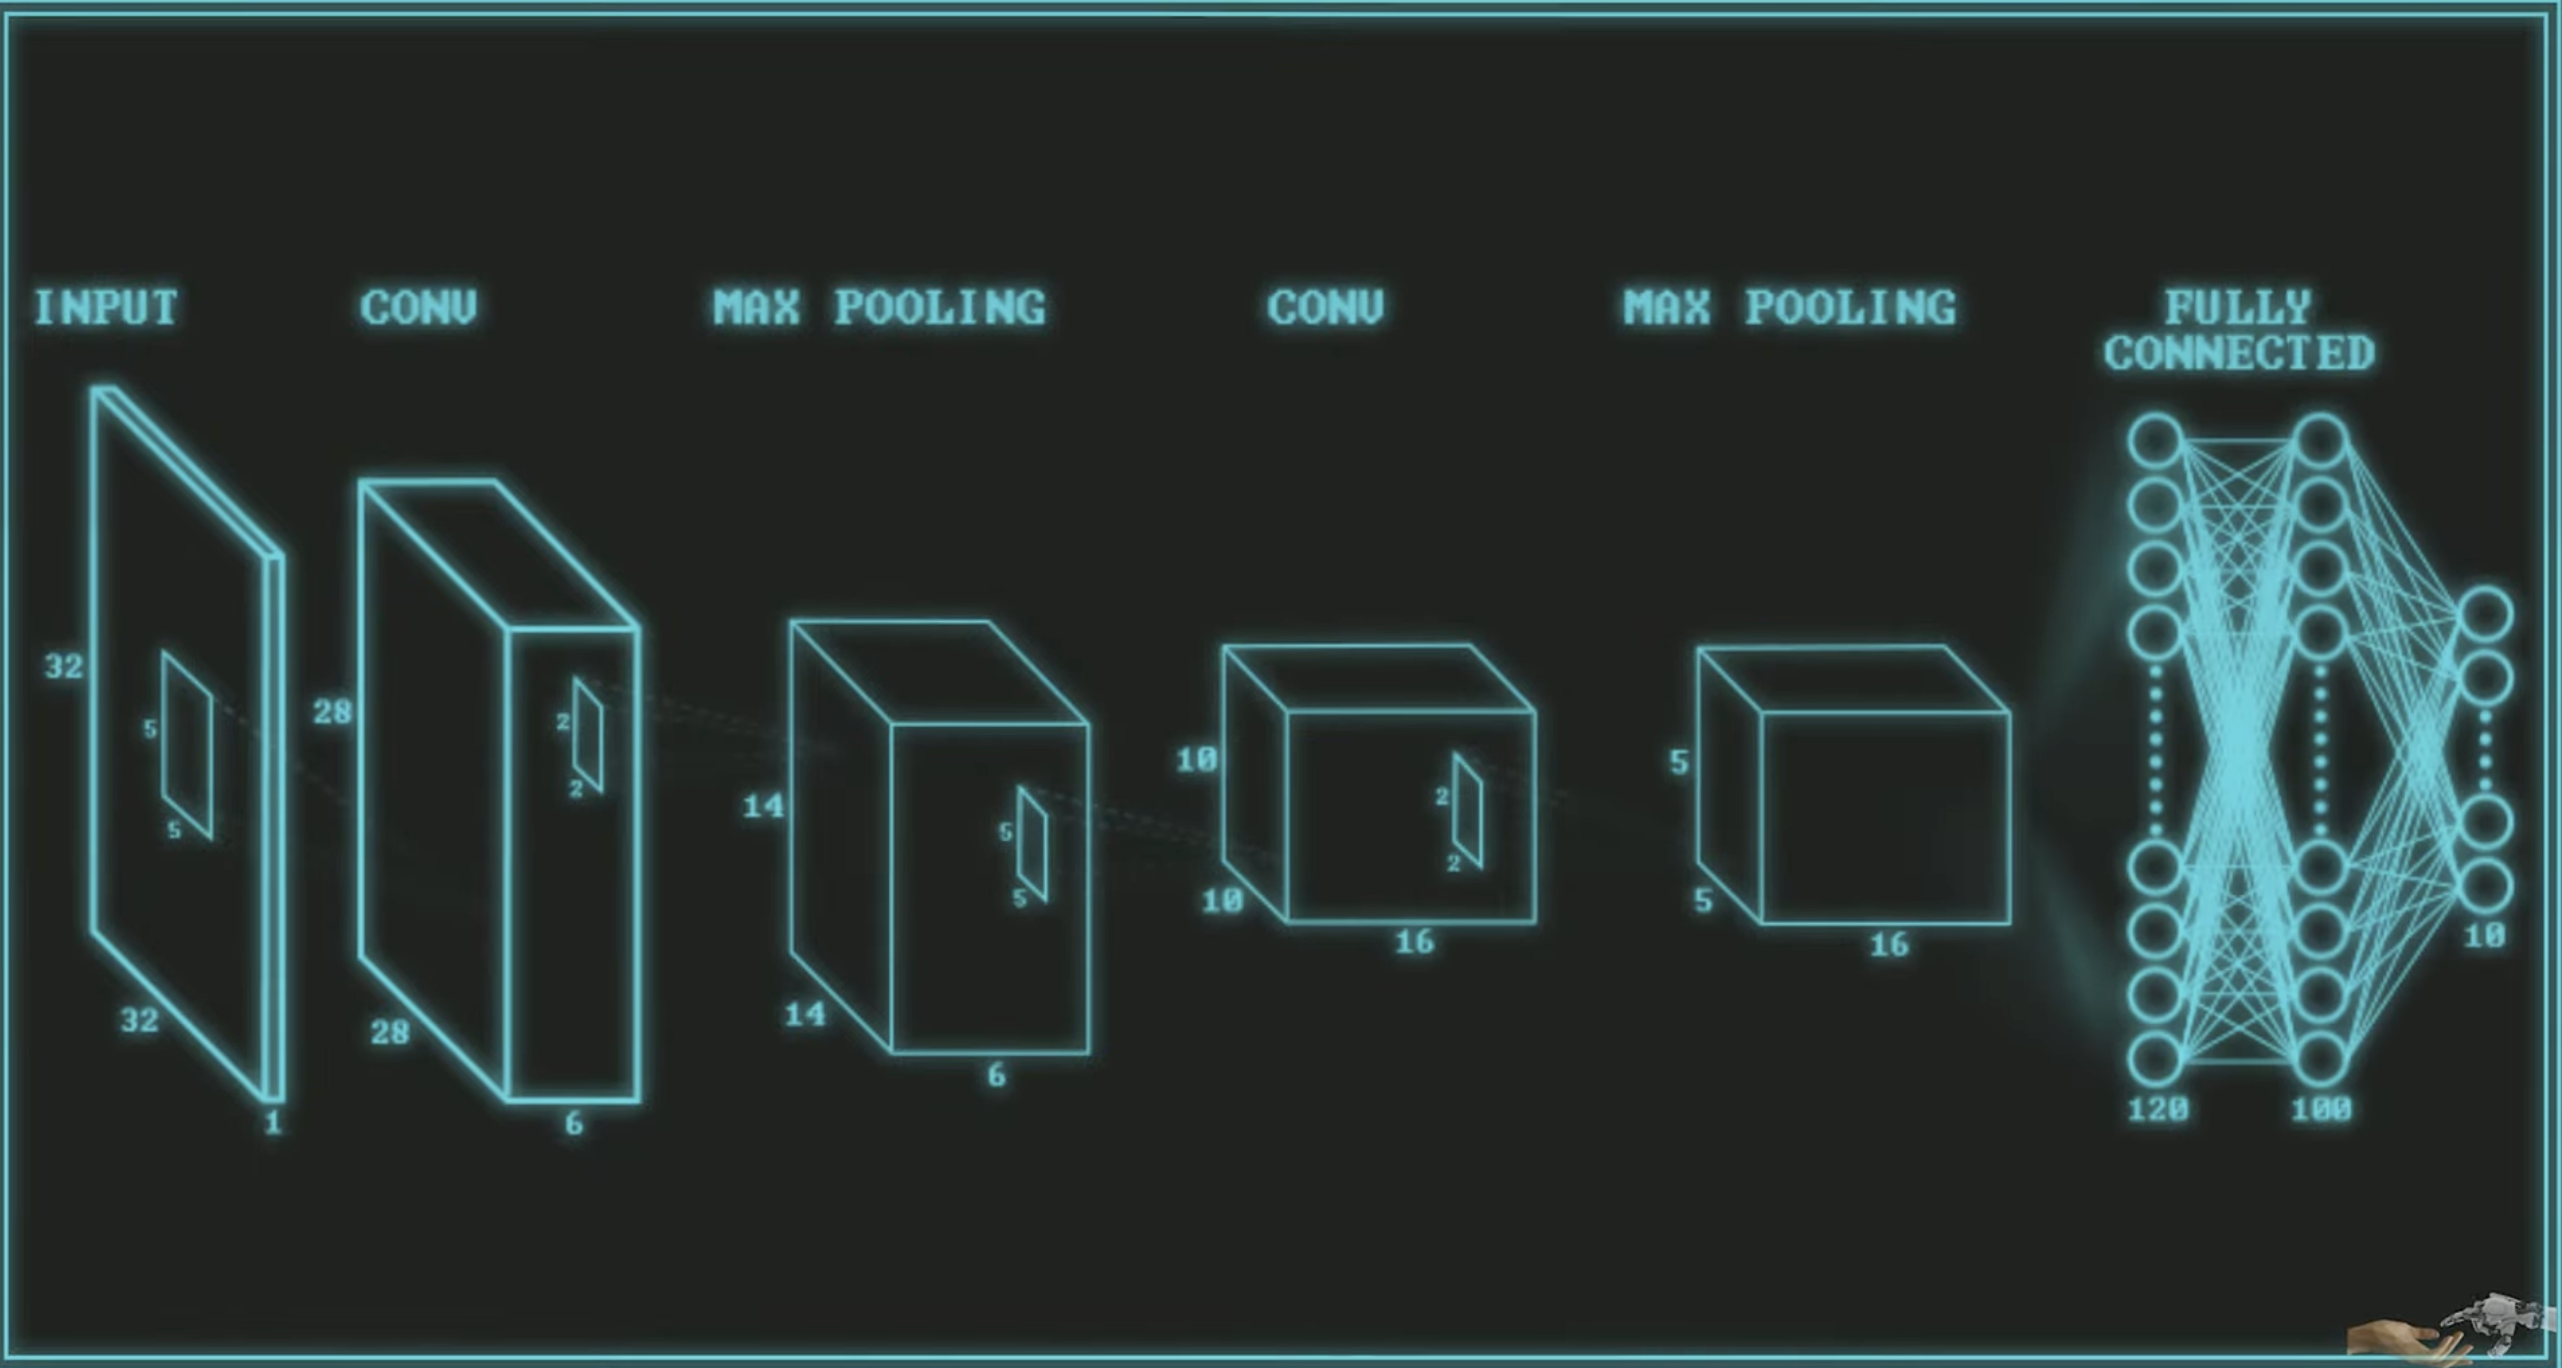

input image: (64, 1, 28, 28)
- 64 grayscaled (channel=1) 28x28 image

```Conv2d(1,32,kernel_size=3,padding=1)``` --> (64, 32, 28, 28)
- inputs 1 channel -> outputs 32 channels
- extract features

```MaxPool2d(2)``` --> (64,32,14,14)
- from 2x2 area, only the max value remains -> half the size (downsampling)

```Conv2d(32, 64, kernel_size-3, padding=1)``` -> (64, 64, 14, 14)
- gets 32 channels in and outputs 64 channels
- extract complex features from extracted feature (abstraction)

```MaxPool2d(2)``` -> (64, 64, 7, 7)
- downsampling again

```Flatten``` -> (64, 3136)
- 64 * 7 * 7 = 3136
- flatten 3D into 1D vector (cuz now we have to feed it into FC for classification

> conv extracts features, fc classifies.

```Linear(3136->128) -> Linear(128->10)``` -> (64,10)
- 10: score for 0~9 (logit)
- highest logit = model's prediction



##5. Train Function

In [18]:
def train(model, loader, criterion, optimizer):
  model.train() #convert to model train mode
  running_loss = 0.0 #initialize cumulative loss
  correct = 0
  total = 0

  for images, labels in loader: #data load loads image 64 (batch)
    optimizer.zero_grad() #pytorch accumulates grad by default -> clear grad of prev batch
    outputs = model(images) #forward pass: returns (64, 10) size logit (0~9)
    loss = criterion(outputs, labels) #Cross-Entropy
    loss.backward() #backward pass (backprop)
    optimizer.step() #param update using gradient (params -= lr * grads)

    running_loss += loss.item() #.item() transforms tensor -> scalar & accumulates them.
    _, predicted = outputs.max(1) #select the index with highest score out of 10, X need score itself.
    correct += predicted.eq(labels).sum().item()
    total += labels.size(0) #accumulate batch size (64)

  avg_loss = running_loss / len(loader)
  accuracy = 100. * correct / total

  return avg_loss, accuracy

##6. Evaluate

In [19]:
def evaluate(model, loader, criterion):
  model.eval() #conver to eval mode -> deactivate dropout (use all neuron)
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
  #deactivate autograd engine as backprop unnecessary during evaluation
  #-> save memory + improve speed

    for images, labels in loader:
      outputs = model(images) #only forward pass
      loss = criterion(outputs, labels) #compute loss

      running_loss += loss.item()
      _, predicted = outputs.max(1)
      correct += predicted.eq(labels).sum().item()
      total += labels.size(0)

  avg_loss = running_loss / len(loader)
  accuracy = 100. * correct / total

  return avg_loss, accuracy


##Train vs. Evaluate
```
─────────────────────────────────────────
model.train()                   model.eval()
dropout 활성화                  dropout 비활성화

optimizer.zero_grad()           with torch.no_grad()
loss.backward()                 → gradient 계산 자체를 안 함
optimizer.step()
→ 가중치 업데이트 O             → 가중치 업데이트 X
````

##7. Training Loop with Early Stopping

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 20
best_acc = 0
patience = 3 #if test acc not getting better 3 in a row -> stop
counter = 0
#for history
train_losses, test_losses = [], []
train_accs, test_accs= [], []

for epoch in range(EPOCHS):
  tr_loss, tr_acc = train(model, train_loader, criterion, optimizer)
  te_loss, te_acc = evaluate(model, test_loader, criterion)

  train_losses.append(tr_loss)
  train_accs.append(tr_acc)
  test_losses.append(te_loss)
  test_accs.append(te_acc)

  print(f"Epoch [{epoch+1}/{EPOCHS}]")
  print(f"  Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}%")
  print(f"  Test  Loss: {te_loss:.4f} | Test  Acc: {te_acc:.2f}%")

  if te_acc > best_acc:
    best_acc = te_acc
    counter = 0
    torch.save(model.state_dict(), 'best_model.pth') #save weights of best model
    print(f"  Best Model saved: (acc: {best_acc:.2f}%)")
  else:
    counter += 1
    print(f"  patience: {counter}/{patience}")
    if counter >= patience:
      print(f"\nEarly stopping. Best Test Acc: {best_acc:.2f}%")
      break

#once training is done, load the best model's params.
model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded!")

Epoch [1/20]
  Train Loss: 0.2630 | Train Acc: 91.90%
  Test  Loss: 0.0456 | Test  Acc: 98.56%
  Best Model saved: (acc: 98.56%)
Epoch [2/20]
  Train Loss: 0.0981 | Train Acc: 97.19%
  Test  Loss: 0.0446 | Test  Acc: 98.54%
  patience: 1/3
Epoch [3/20]
  Train Loss: 0.0704 | Train Acc: 97.86%
  Test  Loss: 0.0300 | Test  Acc: 99.03%
  Best Model saved: (acc: 99.03%)
Epoch [4/20]
  Train Loss: 0.0582 | Train Acc: 98.24%
  Test  Loss: 0.0287 | Test  Acc: 99.02%
  patience: 1/3
Epoch [5/20]
  Train Loss: 0.0490 | Train Acc: 98.53%
  Test  Loss: 0.0337 | Test  Acc: 98.97%
  patience: 2/3
Epoch [6/20]
  Train Loss: 0.0425 | Train Acc: 98.70%
  Test  Loss: 0.0253 | Test  Acc: 99.20%
  Best Model saved: (acc: 99.20%)
Epoch [7/20]
  Train Loss: 0.0386 | Train Acc: 98.79%
  Test  Loss: 0.0283 | Test  Acc: 99.18%
  patience: 1/3
Epoch [8/20]
  Train Loss: 0.0354 | Train Acc: 98.89%
  Test  Loss: 0.0300 | Test  Acc: 99.17%
  patience: 2/3
Epoch [9/20]
  Train Loss: 0.0308 | Train Acc: 99.02%
  Te

## 8. Plot Loss & Accuracy Curves

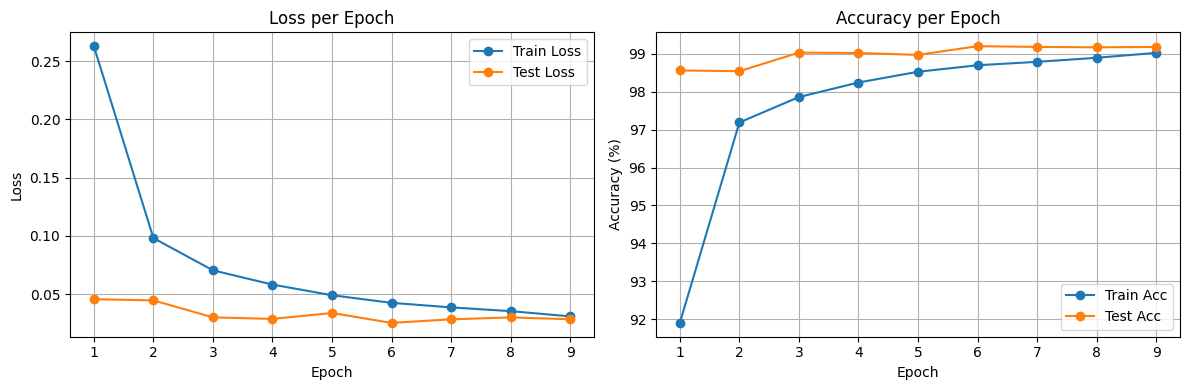

In [21]:
epochs = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
ax1.plot(epochs, test_losses,  label='Test Loss',  marker='o')
ax1.set_title('Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(epochs, train_accs, label='Train Acc', marker='o')
ax2.plot(epochs, test_accs,  label='Test Acc',  marker='o')
ax2.set_title('Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 9. Confusion Matrix
- **Rows** = true label
- **Columns** = predicted label
- **Diagonal** = correct predictions
- **Off-diagonal** = mistakes (e.g. row=4, col=9 means model predicted 9 when true label was 4)

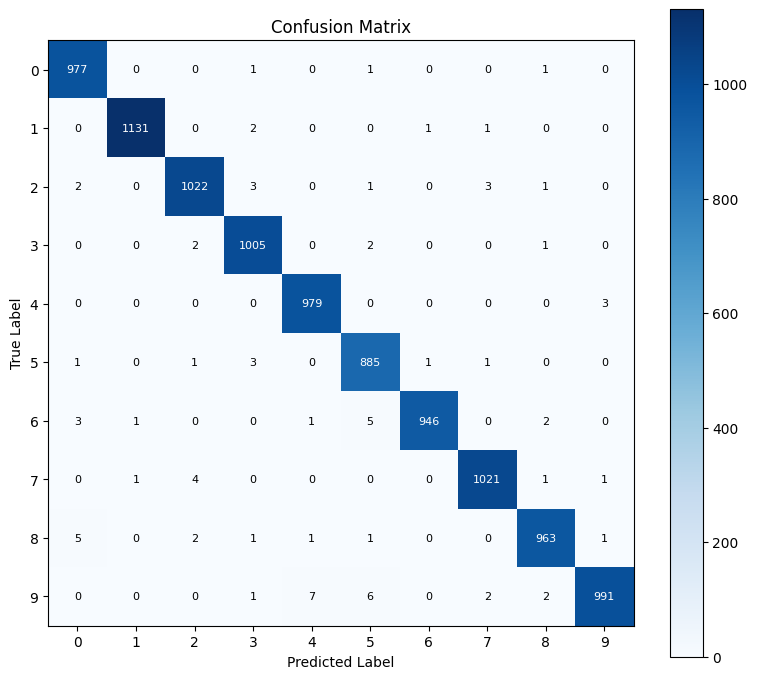

Top confused pairs (true -> predicted):
  9 -> 4 : 7 times
  9 -> 5 : 6 times
  8 -> 0 : 5 times
  6 -> 5 : 5 times
  7 -> 2 : 4 times


In [22]:
num_classes = 10
cm = np.zeros((num_classes, num_classes), dtype=int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs  = model(images)
        _, preds = outputs.max(1)
        for t, p in zip(labels.numpy(), preds.numpy()):
            cm[t][p] += 1

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(cm, cmap='Blues')
plt.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)])
ax.set_yticklabels([str(i) for i in range(num_classes)])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

thresh = cm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, str(cm[i][j]),
                ha='center', va='center',
                color='white' if cm[i][j] > thresh else 'black',
                fontsize=8)
plt.tight_layout()
plt.show()

# Top confused pairs
print('Top confused pairs (true -> predicted):')
off_diag = [(cm[i][j], i, j) for i in range(num_classes)
                               for j in range(num_classes) if i != j]
for count, true, pred in sorted(off_diag, reverse=True)[:5]:
    print(f'  {true} -> {pred} : {count} times')

## 10. Wrong Prediction Gallery
Title format: `T:{true label}  P:{predicted label}`

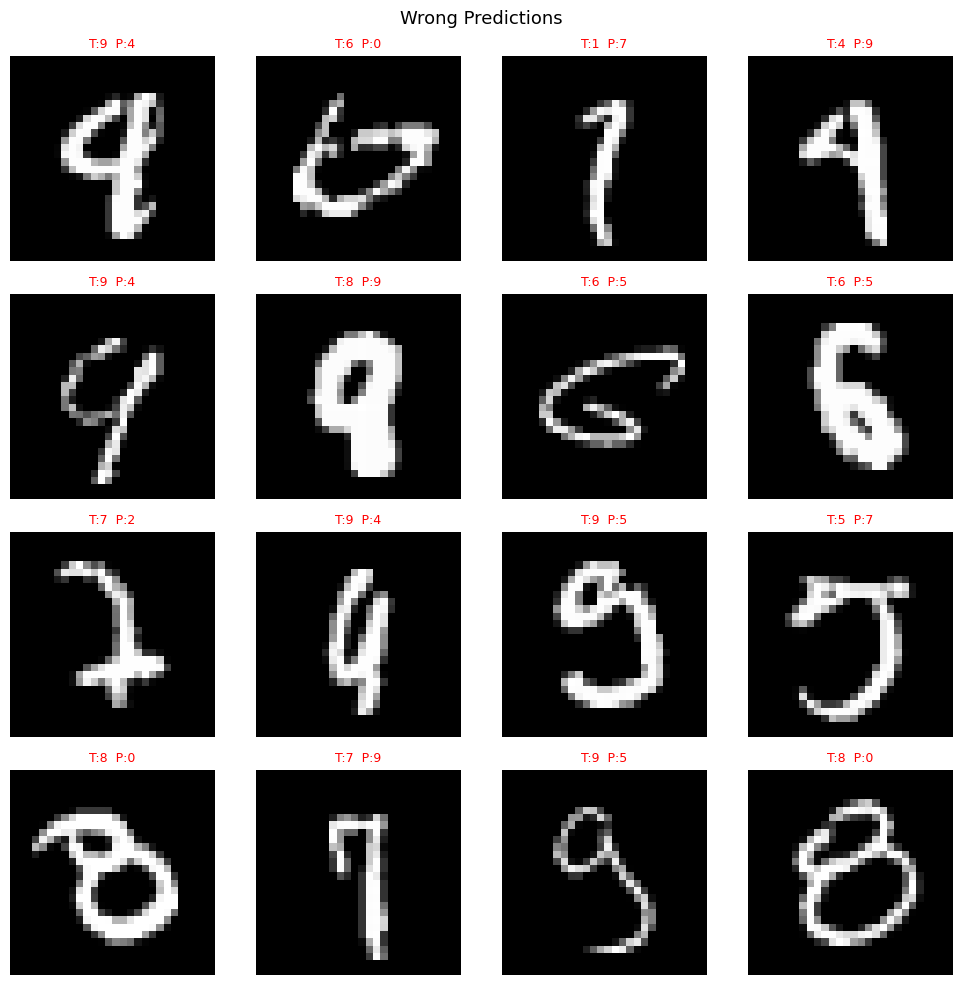

In [23]:
n = 16
wrong_images, wrong_true, wrong_pred = [], [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs  = model(images)
        _, preds = outputs.max(1)
        mask     = preds.ne(labels)      # True where prediction is wrong
        wrong_images.append(images[mask])
        wrong_true.append(labels[mask])
        wrong_pred.append(preds[mask])
        if sum(len(w) for w in wrong_images) >= n:
            break

wrong_images = torch.cat(wrong_images)[:n]
wrong_true   = torch.cat(wrong_true)[:n]
wrong_pred   = torch.cat(wrong_pred)[:n]

cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))

for i, ax in enumerate(axes.flat):
    if i < len(wrong_images):
        img = wrong_images[i].squeeze().numpy()
        img = (img * 0.5) + 0.5          # denormalise [-1,1] -> [0,1] for display
        ax.imshow(img, cmap='gray')
        ax.set_title(f'T:{wrong_true[i].item()}  P:{wrong_pred[i].item()}',
                     fontsize=9, color='red')
    ax.axis('off')

plt.suptitle('Wrong Predictions', fontsize=13)
plt.tight_layout()
plt.show()

#